Analyzing dataset: Retail_Rocket
Stats for Retail_Rocket:
  - Items: 417053
  - Users: 96057
  - Sessions: 314900
  - Interactions: 843631
  - Avg sessions per user: 3.28
  - Avg interactions per session: 2.68
  - Avg interactions per user: 8.78
  - Additional Info Statistics:
      * event (categorical): count=843631, top categories=[('view', 794323), ('addtocart', 35041), ('transaction', 14267)]
      * transactionid (categorical): count=843631, top categories=[('', 829364), (7063.0, 31), (765.0, 28)]
-------------------------------------------------------
Analyzing dataset: LFM-BeyMS
Stats for LFM-BeyMS:
  - Items: 1084922
  - Users: 4148
  - Sessions: 1636364
  - Interactions: 16687363
  - Avg sessions per user: 394.49
  - Avg interactions per session: 10.20
  - Avg interactions per user: 4022.99
  - Additional Info Statistics:
-------------------------------------------------------
Analyzing dataset: Globo
Stats for Globo:
  - Items: 364046
  - Users: 322897
  - Sessions: 1048594


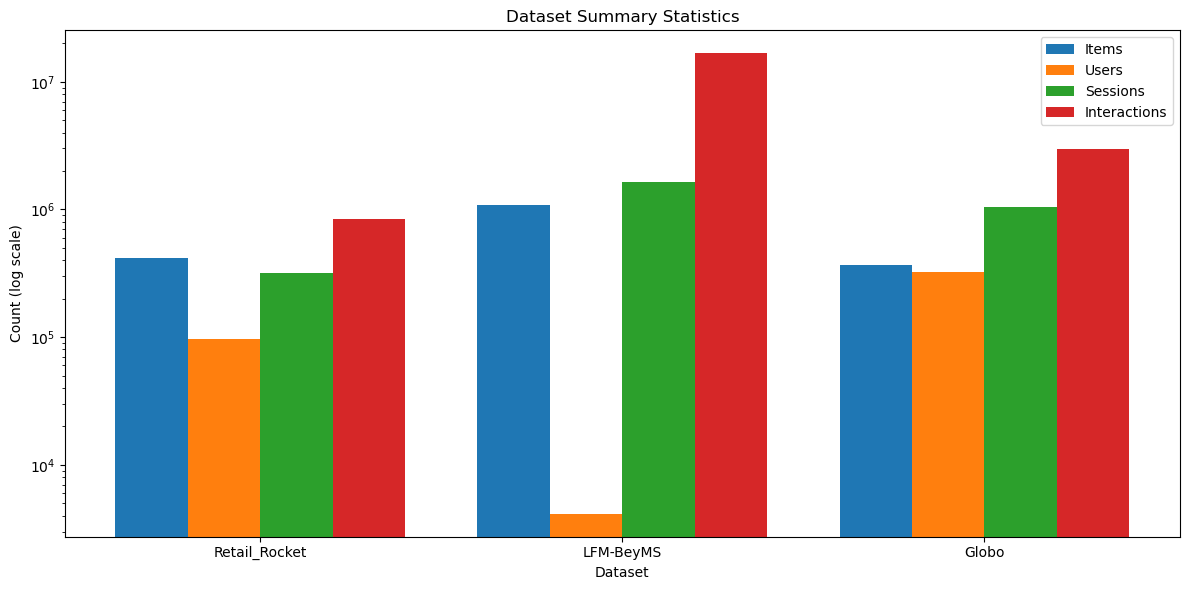

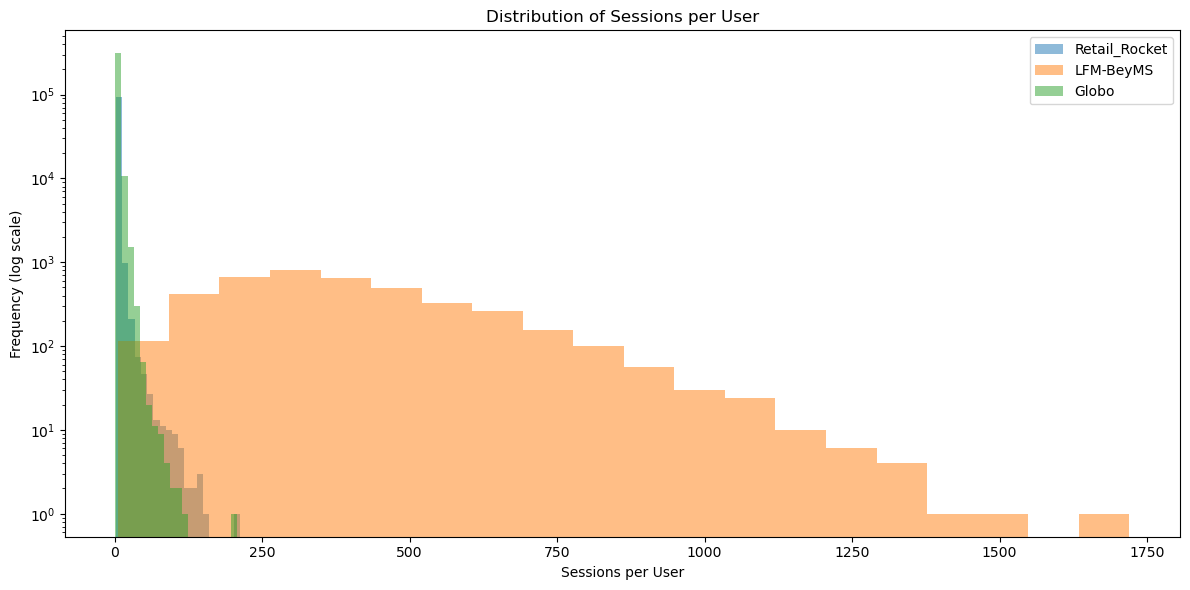

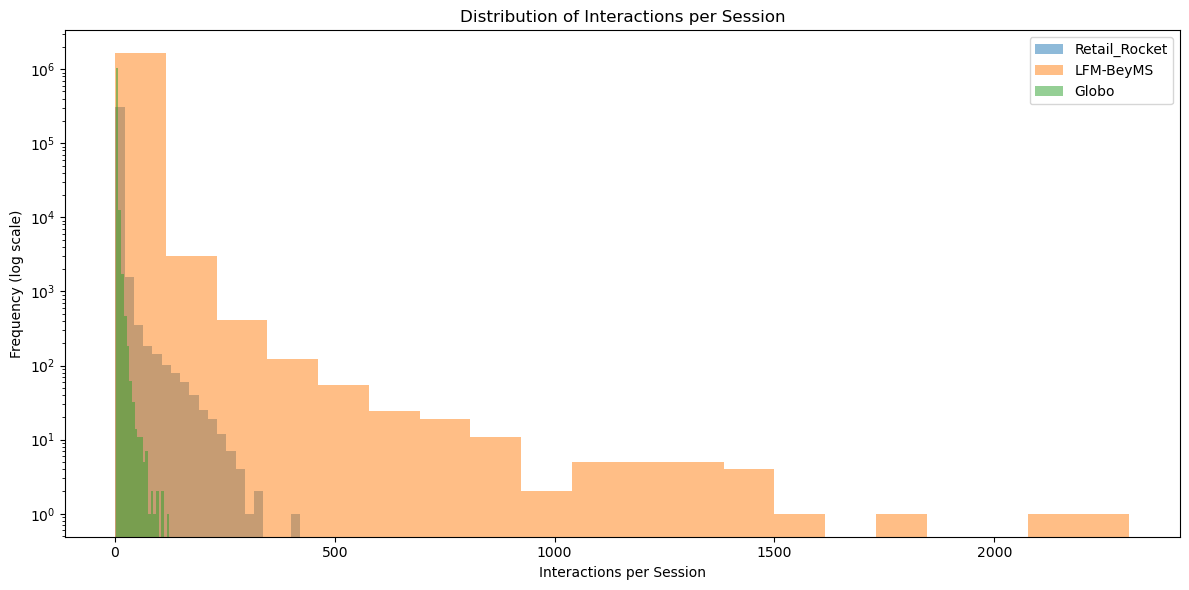

In [4]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def analyze_additional_info(interactions):
    """
    interactions.json 파일의 "index" 정보를 활용하여 
    각 interaction의 additional_info를 추출한 뒤,
    각 필드별로 숫자형 통계 (평균, 중앙값, 표준편차, 최솟값, 최댓값) 또는 
    범주형 빈도분포를 계산한다.
    """
    add_index = interactions["index"].get("add_index", {})
    add_info_pos = interactions["index"].get("add_info", 2)
    
    # 각 필드별 값들을 저장할 딕셔너리 초기화
    add_values = { key: [] for key in add_index.keys() }
    
    data = interactions.get("data", {})
    for user, sessions in data.items():
        for session in sessions:
            for interaction in session:
                if len(interaction) > add_info_pos:
                    additional_info = interaction[add_info_pos]
                    for key, pos in add_index.items():
                        if pos < len(additional_info):
                            add_values[key].append(additional_info[pos])
    
    add_stats = {}
    for key, values in add_values.items():
        # 숫자형 변환 시도
        numeric_possible = True
        numeric_values = []
        for v in values:
            try:
                numeric_values.append(float(v))
            except (ValueError, TypeError):
                numeric_possible = False
                break
        if numeric_possible and numeric_values:
            numeric_values = np.array(numeric_values)
            stats_dict = {
                "mean": float(np.mean(numeric_values)),
                "median": float(np.median(numeric_values)),
                "std": float(np.std(numeric_values)),
                "min": float(np.min(numeric_values)),
                "max": float(np.max(numeric_values)),
                "count": len(numeric_values)
            }
            add_stats[key] = {"type": "numeric", "stats": stats_dict}
        else:
            counter = Counter(values)
            add_stats[key] = {"type": "categorical", "counter": counter, "count": len(values)}
    return add_stats

def analyze_dataset(folder):
    """
    주어진 폴더 내의 item_metadata.json과 interactions.json 파일을 읽어
    데이터셋의 기본 통계와 additional_info의 요약 통계를 계산한다.
    """
    # item_metadata.json 읽기 (item id를 key로 메타정보를 value로 가짐)
    item_metadata_path = os.path.join(folder, 'item_metadata.json')
    with open(item_metadata_path, 'r', encoding='utf-8') as f:
        item_metadata = json.load(f)
    num_items = len(item_metadata)
    
    # interactions.json 읽기
    interactions_path = os.path.join(folder, 'interactions.json')
    with open(interactions_path, 'r', encoding='utf-8') as f:
        interactions = json.load(f)
    
    # 기본 통계 계산
    data = interactions.get("data", {})
    num_users = len(data)
    total_sessions = 0
    total_interactions = 0
    sessions_per_user = []
    interactions_per_session = []
    
    for user, sessions in data.items():
        num_sessions = len(sessions)
        total_sessions += num_sessions
        sessions_per_user.append(num_sessions)
        for session in sessions:
            n_inter = len(session)
            total_interactions += n_inter
            interactions_per_session.append(n_inter)
    
    avg_sessions_per_user = total_sessions / num_users if num_users > 0 else 0
    avg_interactions_per_session = total_interactions / total_sessions if total_sessions > 0 else 0
    avg_interactions_per_user = total_interactions / num_users if num_users > 0 else 0
    
    # additional_info 통계 분석
    additional_stats = analyze_additional_info(interactions)
    
    stats = {
        "num_items": num_items,
        "num_users": num_users,
        "total_sessions": total_sessions,
        "total_interactions": total_interactions,
        "avg_sessions_per_user": avg_sessions_per_user,
        "avg_interactions_per_session": avg_interactions_per_session,
        "avg_interactions_per_user": avg_interactions_per_user,
        "sessions_per_user": sessions_per_user,
        "interactions_per_session": interactions_per_session,
        "additional_stats": additional_stats
    }
    return stats

def plot_stats(dataset_names, stats_list):
    """
    각 데이터셋의 기본 통계를 로그 스케일로 바 차트와 히스토그램으로 시각화한다.
    """
    num_datasets = len(stats_list)
    indices = np.arange(num_datasets)
    width = 0.2

    # 기본 통계: 아이템, 유저, 세션, 인터랙션
    num_items = [s["num_items"] for s in stats_list]
    num_users = [s["num_users"] for s in stats_list]
    total_sessions = [s["total_sessions"] for s in stats_list]
    total_interactions = [s["total_interactions"] for s in stats_list]

    plt.figure(figsize=(12, 6))
    plt.bar(indices - 1.5 * width, num_items, width, label='Items')
    plt.bar(indices - 0.5 * width, num_users, width, label='Users')
    plt.bar(indices + 0.5 * width, total_sessions, width, label='Sessions')
    plt.bar(indices + 1.5 * width, total_interactions, width, label='Interactions')
    plt.xticks(indices, dataset_names)
    plt.xlabel('Dataset')
    plt.ylabel('Count (log scale)')
    plt.yscale('log')
    plt.title('Dataset Summary Statistics')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 유저당 세션 분포
    plt.figure(figsize=(12, 6))
    for i, stats in enumerate(stats_list):
        plt.hist(stats["sessions_per_user"], bins=20, alpha=0.5, label=f'{dataset_names[i]}')
    plt.xlabel('Sessions per User')
    plt.ylabel('Frequency (log scale)')
    plt.yscale('log')
    plt.title('Distribution of Sessions per User')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 세션당 인터랙션 분포
    plt.figure(figsize=(12, 6))
    for i, stats in enumerate(stats_list):
        plt.hist(stats["interactions_per_session"], bins=20, alpha=0.5, label=f'{dataset_names[i]}')
    plt.xlabel('Interactions per Session')
    plt.ylabel('Frequency (log scale)')
    plt.yscale('log')
    plt.title('Distribution of Interactions per Session')
    plt.legend()
    plt.tight_layout()
    plt.show()

def main(dataset_folders):
    """
    dataset_folders에 각 데이터셋의 폴더 경로(예: ["./dataset1", "./dataset2", "./dataset3"])가 들어있다.
    각 데이터셋에 대해 기본 통계와 additional_info 요약 통계를 출력하고, 기본 통계를 시각화한다.
    """
    stats_list = []
    dataset_names = []
    for folder in dataset_folders:
        dataset_name = os.path.basename(os.path.normpath(folder))
        dataset_names.append(dataset_name)
        print(f"Analyzing dataset: {dataset_name}")
        stats = analyze_dataset(folder)
        stats_list.append(stats)
        
        print(f"Stats for {dataset_name}:")
        print(f"  - Items: {stats['num_items']}")
        print(f"  - Users: {stats['num_users']}")
        print(f"  - Sessions: {stats['total_sessions']}")
        print(f"  - Interactions: {stats['total_interactions']}")
        print(f"  - Avg sessions per user: {stats['avg_sessions_per_user']:.2f}")
        print(f"  - Avg interactions per session: {stats['avg_interactions_per_session']:.2f}")
        print(f"  - Avg interactions per user: {stats['avg_interactions_per_user']:.2f}")
        print("  - Additional Info Statistics:")
        for key, info in stats["additional_stats"].items():
            if info["type"] == "numeric":
                s = info["stats"]
                print(f"      * {key} (numeric): count={s['count']}, mean={s['mean']:.2f}, median={s['median']:.2f}, std={s['std']:.2f}, min={s['min']}, max={s['max']}")
            else:
                top_categories = Counter(info["counter"]).most_common(3)
                print(f"      * {key} (categorical): count={info['count']}, top categories={top_categories}")
        print("-------------------------------------------------------")
        
    # 기본 통계 시각화
    plot_stats(dataset_names, stats_list)



if __name__ == "__main__":
    # 데이터셋 폴더 경로 리스트 (실제 경로로 수정 필요)
    dataset_folders = [
        '/home/jy1559/Mar2025_Module/Datasets/Retail_Rocket',
        '/home/jy1559/Mar2025_Module/Datasets/LFM-BeyMS',
        '/home/jy1559/Mar2025_Module/Datasets/Globo'
    ]
    main(dataset_folders)
